In [1]:
#!/usr/bin/env python
import warnings
from math import sin, cos, atan, sqrt, radians
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def normalized_slip_tendency(
        stress_directions, stress_difference_ratio, fault_plane,
        friction_coefficient):
    """
    Calculate normalized slip tendency given..

      * directions of principal stress axes (should be orthogonal!)
      * difference ratio of principal stresses
      * fault plane orientation
      * friction coefficient

    See e.g.

      * Morris et.al. (Geology v.24 no.3 p.275-278, March 1996)
      * Neves et.al. (2009, doi: 10.1016/j.cageo.2009.03.008)
      * Neves et.al. (2015, corrected formulas of Neves 2009;
                      doi: 10.1016/j.tecto.2015.07.023)
      * Worum et.al. (2004, doi: 10.1029/2003JB002586)

    :type stress_directions: :class:`numpy.ndarray` or nested list/tuple
    :param stress_directions: Directions of principal stress axes given as a
        list of three (azimuth, plunge) tuples ordered by stress magnitudes,
        i.e. ordered from highest compressive stress "sigma1" to least
        compressive stress direction "sigma3" (e.g.
        ``[(0, 0), (90, 90), (90, 0)]`` for a strike slip regime with
        North-South aligned maximum stress).
    :type stress_difference_ratio: float
    :param stress_difference_ratio: Difference ratio of principal stress
        magnitudes (from 0 to 1), defined as
        ``(sigma1 - sigma2) / (sigma1 - sigma3)``.
    :type fault_plane: 2-tuple of float
    :param fault_plane: Orientation of fault plane given as strike and dip
        (e.g. ``(200, 70)`` for a SSW-NNE striking and sub-vertically westwards
        dipping fault).
    :type friction_coefficient: float
    :param friction_coefficient: Friction coefficient of fault (from 0 to 1.)
    :rtype: float
    :returns: Normalized slip tendency of fault, ranging from 0 to 1.
    """
    stress_directions = np.radians(stress_directions)
    fault_plane = np.radians(fault_plane)
    # rotation matrix from principal stress system to XYZ
    coord_conversion = np.empty((3, 3))
    coord_conversion[0, :] = (np.cos(stress_directions[:, 0]) *
                              np.cos(stress_directions[:, 1]))
    coord_conversion[1, :] = (np.sin(stress_directions[:, 0]) *
                              np.cos(stress_directions[:, 1]))
    coord_conversion[2, :] = -np.sin(stress_directions[:, 1])
    # check orthogonality of principal stress axes
    for i in range(0, 3):
        for j in range(i+1, 3):
            if np.abs(np.dot(coord_conversion[i], coord_conversion[j])) > 0.09:
                msg = "Non-orthogonal principal stress directions!"
                warnings.warn(msg)
    # fault plane normal vector in XYZ
    fault_normal = np.empty((3, 1))
    fault_normal[0] = -sin(fault_plane[0]) * sin(fault_plane[1])
    fault_normal[1] = cos(fault_plane[0]) * sin(fault_plane[1])
    fault_normal[2] = cos(fault_plane[1])
    # fault normal vector in principal stress system
    coord_conversion_inv = np.linalg.inv(coord_conversion)
    coord_conversion_inv[np.abs(coord_conversion_inv) < 1e-4] = 0
    fault_normal = np.dot(coord_conversion_inv, fault_normal)
    l, m, n = fault_normal
    # normal and shear stress on fault plane
    shape_ratio = 1.0 - stress_difference_ratio
    phi = atan(friction_coefficient)
    shear_stress_k1 = sqrt(
        (1 - shape_ratio)**2 * l**2 * m**2 +
        shape_ratio**2 * m**2 * n**2 +
        n**2 * l**2)
    csc_phi = 1.0 / sin(phi)
    normal_stress_k1 = (
        0.5 * (csc_phi + 1.0) - (1.0 - shape_ratio) * m**2 - n**2)
    slip_tendency = shear_stress_k1 / (normal_stress_k1 * friction_coefficient)
    return slip_tendency


def calculate_stress_difference_ratio(sigma1, sigma2, sigma3):
    """
    Calculate stress difference ratio, based on given stress magnitudes of
    sigma1 >= sigma2 >= sigma3.
    """
    assert sigma1 >= sigma2 >= sigma3
    stress_difference_ratio = float(sigma1 - sigma2) / float(sigma1 - sigma3)
    assert 0 <= stress_difference_ratio <= 1
    return stress_difference_ratio


def plot_fault(ax, xy, strike, dip, slip_tendency, length=10, linewidth=15,
               annotate=True):
    cmap = matplotlib.cm.get_cmap('viridis')
    # no need to normalize as values are already in interval [0, 1]
    color = cmap(slip_tendency)[0]
    x_end = xy[0] + cos(radians(90 - strike)) * length
    y_end = xy[1] + sin(radians(90 - strike)) * length
    ax.plot((xy[0], x_end), (xy[0], y_end), color=color, lw=linewidth)
    if annotate:
        info = 'Strike: %.0f\nDip: %.0f\nSlip Tendency: %.2f' % (strike, dip, slip_tendency)
        ax.text((xy[0] + x_end) / 2.0, (xy[1] + y_end) / 2.0, info, ha='center', va='center')

Strike: 47  Dip: 90    Slip Tendency: 0.83
Strike: 25  Dip: 90    Slip Tendency: 0.98
Strike: 75  Dip: 90    Slip Tendency: 0.30


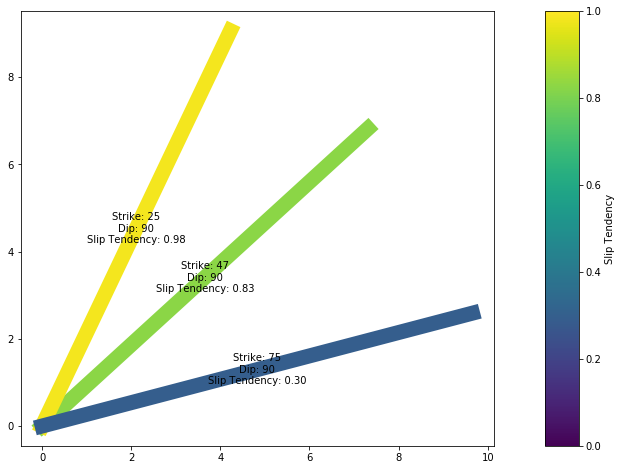

In [2]:
# Example Unterhaching

friction_coefficient = 0.6

# faults given as (strike, dip)
faults = [(47, 90), (25, 90), (75, 90)]

# sigma directions given as (azimuth, plunge)
sigma1 = (0, 0)
sigma2 = (90, 90)
sigma3 = (90, 0)

sigma1_mag = 5
sigma2_mag = 1
sigma3_mag = 0.5

stress_difference_ratio = calculate_stress_difference_ratio(
    sigma1_mag, sigma2_mag, sigma3_mag)

fig, (ax, cb) = plt.subplots(
    figsize=(10, 8), ncols=2, gridspec_kw={'width_ratios': (14, 1)})
for fault in faults:
    strike, dip = fault
    slip_tendency = normalized_slip_tendency(
        stress_directions=(sigma1, sigma2, sigma3),
        stress_difference_ratio=stress_difference_ratio,
        fault_plane=fault,
        friction_coefficient=friction_coefficient)
    print('Strike: %.0f  Dip: %.0f    Slip Tendency: %.2f' % (strike, dip, slip_tendency))
    plot_fault(ax, xy=(0, 0), strike=strike, dip=dip, slip_tendency=slip_tendency)
matplotlib.colorbar.ColorbarBase(
    ax=cb, cmap='viridis', orientation='vertical', label='Slip Tendency')
plt.show()

Given the following fault planes:
F2 Strike: 243N Dip: 80 Length 1.0 km  Antitheter and
B2 Strike: 89N  Dip: 75 Length: 1.3 km Syntheter
Identify the larger Slip Tendency of both (preferable fault for re-injection). 
For a first estimate use the same settings of friction and stress magnitude as well as directions from the Unterhaching example. Vary the not so well known parameter to estimate the maximum possible slip tendency.